# Embeddings

In [2]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from model import InputEmbeddings  # Notre impl√©mentation du papier
from model import PositionalEncoding

Ce notebook explore les embeddings utilis√©s dans l'architecture Transformer:
1. Token Embeddings: repr√©sentations vectorielles des mots
2. Positional Encoding: information sur la position des tokens dans la s√©quence

Nous allons visualiser chaque composante et comprendre pourquoi ces choix techniques ont √©t√© faits
dans le papier "Attention Is All You Need".

In [3]:
# D√©finissons un petit vocabulaire d'exemple
vocab = ["Je", "vais", "√†", "la", "l", "maison", "√©cole", "en", "l√©gende", ".", "<PAD>"]
vocab_size = len(vocab)
d_model = 8  # Gardons une dimension r√©duite pour la visualisation

In [4]:
# Cr√©ation des dictionnaires de conversion
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

Les embeddings de tokens transforment les indices de tokens (entiers) en vecteurs denses.
- Chaque token est repr√©sent√© par un vecteur de dimension d_model
- Dans le Transformer original: d_model = 512
- La multiplication par ‚àöd_model aide √† maintenir des gradients appropri√©s

In [5]:
# Initialisation de la couche d'embedding
embedding_layer = InputEmbeddings(d_model, vocab_size)

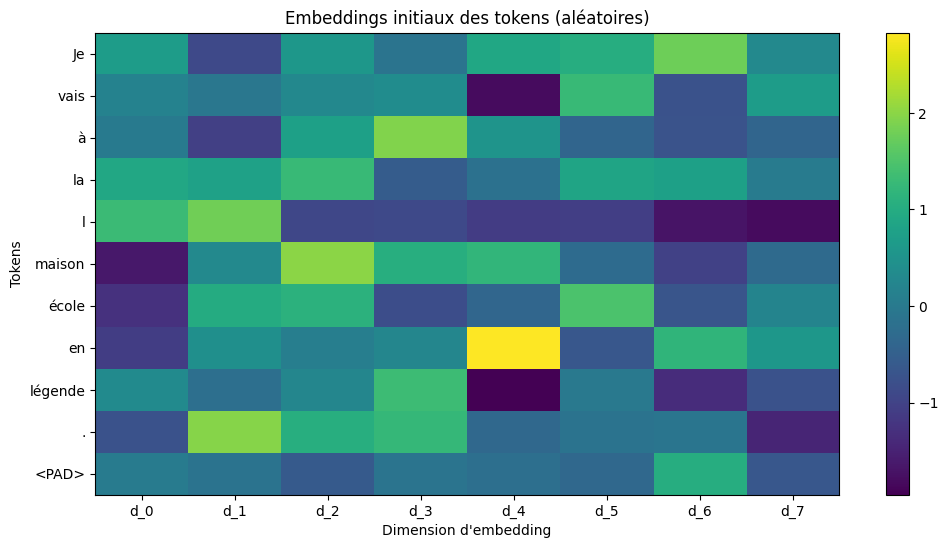

In [6]:
# Visualisation des embeddings initiaux (al√©atoires)
plt.figure(figsize=(12, 6))
plt.imshow(embedding_layer.embedding.weight.detach().numpy(), aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Embeddings initiaux des tokens (al√©atoires)")
plt.xlabel("Dimension d'embedding")
plt.ylabel("Tokens")
plt.yticks(range(len(vocab)), vocab)
plt.xticks(range(d_model), [f'd_{i}' for i in range(d_model)])
plt.show()

## Les embeddings initiaux : transformation des mots en vecteurs

```python
class InputEmbeddings(nn.Module):
    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)
```

Les embeddings sont la premi√®re √©tape cruciale du Transformer. Leur r√¥le est de transformer chaque mot (repr√©sent√© par un indice entier) en un vecteur dense de dimension `d_model`.

**Comment √ßa marche ?**

1. **La couche d'embedding** (`nn.Embedding`)
   - C'est une simple table de correspondance (lookup table)
   - Pour un vocabulaire de taille `vocab_size`, elle cr√©e une matrice de taille `vocab_size √ó d_model`
   - Chaque ligne de cette matrice repr√©sente un mot du vocabulaire

2. **Initialisation al√©atoire**
   - Au d√©but, les vecteurs sont initialis√©s al√©atoirement
   - C'est comme donner une "feuille blanche" au mod√®le
   - Ces valeurs vont s'ajuster pendant l'entra√Ænement pour capturer le sens des mots

3. **Le forward et l'apprentissage**
   - La fonction `forward` r√©cup√®re simplement les vecteurs correspondant aux indices des mots
   - La multiplication par `sqrt(d_model)` est un facteur d'√©chelle qui aide √† la stabilit√©
   - Pendant l'entra√Ænement, ces embeddings seront mis √† jour par r√©tropropagation

**Exemple concret**

Si on a les mots "chat" et "chien" :
- Au d√©but : vecteurs al√©atoires sans relation
- Apr√®s entra√Ænement : vecteurs probablement proches car ces mots apparaissent dans des contextes similaires

Cette repr√©sentation vectorielle permet au Transformer de traiter les mots math√©matiquement et de capturer leurs relations s√©mantiques.

In [7]:
# Exploration de quelques exemples
token_indices = torch.tensor([word2idx["Je"], word2idx["vais"], word2idx["√†"]])
token_embs = embedding_layer(token_indices)

print(f"Dimension des embeddings: {token_embs.shape}")
print(f"Embedding pour 'Je': {token_embs[0]}")
print(f"Note: Les valeurs sont multipli√©es par ‚àöd_model = {math.sqrt(d_model)}")

Dimension des embeddings: torch.Size([3, 8])
Embedding pour 'Je': tensor([ 1.9399, -2.5293,  1.6158, -0.3076,  2.5629,  2.9269,  5.0038,  0.8713],
       grad_fn=<SelectBackward0>)
Note: Les valeurs sont multipli√©es par ‚àöd_model = 2.8284271247461903


## Positional Encoding

Probl√®me fondamental: les Transformers traitent tous les tokens en parall√®le!

Contrairement aux RNNs qui traitent les tokens s√©quentiellement, les Transformers n'ont pas de notion
intrins√®que d'ordre. Sans information de position, ces deux phrases seraient identiques pour le mod√®le:
- "Le chat mange la souris"
- "La souris mange le chat"

Solution: ajouter explicitement l'information de position aux embeddings.

In [8]:
# Cr√©ons deux phrases d'exemple
sentences = [
    ["Je", "vais", "√†", "la", "maison", "en", "l√©gende", "."],
    ["Je", "vais", "√†", "l", "√©cole", "."]
]

In [9]:
# Conversion en indices
def sentences_to_tensor(sentences):
    max_len = max(len(s) for s in sentences)
    indices = []
    for sent in sentences:
        # Padding √† droite avec <PAD>
        padded = sent + ["<PAD>"] * (max_len - len(sent))
        indices.append([word2idx[w] for w in padded])
    return torch.tensor(indices), max_len

In [10]:
# Cr√©ation du tenseur d'entr√©e
input_tensor, seq_len = sentences_to_tensor(sentences)
print("Phrases converties en indices:")
print(input_tensor)

Phrases converties en indices:
tensor([[ 0,  1,  2,  3,  5,  7,  8,  9],
        [ 0,  1,  2,  4,  6,  9, 10, 10]])


Probl√®me : Les transformers n'ont pas de notion d'ordre s√©quentiel (contrairement aux RNNs) car ils traitent tous les tokens en parall√®le.

Solution : Ajouter un "positional encoding" aux embeddings pour injecter l'information de position

Formule utilis√©e : Fonctions sinus pour les dimensions paires et cosinus pour les dimensions impaires.

$$
PE(pos, 2i) = sin(pos / 10000^{2i/d_{model}})
$$
$$
PE(pos, 2i+1) = cos(pos / 10000^{2i/d_{model}})
$$

o√π:
- pos est la position dans la s√©quence
- i est l'indice de la dimension
- d_model est la dimension du mod√®le

Propri√©t√©s importantes:
1. Les valeurs sont entre -1 et 1
2. Chaque position a un vecteur unique
3. Pour tout offset k fixe, PE(pos+k) peut √™tre exprim√© comme fonction lin√©aire de PE(pos)
4. Permet d'extrapoler √† des longueurs de s√©quences non vues pendant l'entra√Ænement

Alternative: on aurait pu apprendre les embeddings de position, mais les auteurs ont trouv√© que les deux approches donnaient des r√©sultats similaires, et l'encodage sinuso√Ødal
permet une meilleure g√©n√©ralisation.



Examinons l'impl√©mentation dans notre mod√®le:

```python
class PositionalEncoding(nn.Module):
    def init(self, d_model: int, seq_len: int, dropout: float):
        super().init()

        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(seq_len, d_model)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) -(math.log(10000.0) / d_model))

        # On applique sin aux indices pairs et cos aux indices impairs
        pe[:, 0::2] = torch.sin(position div_term)
        pe[:, 1::2] = torch.cos(position div_term)

        # On ajoute la dimension batch
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)
    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x)
```

Points importants:
- div_term calcule efficacement 10000^(2i/d_model)
- register_buffer sauvegarde pe sans l'ajouter aux param√®tres √† optimiser
- Dans forward(), on ajoute simplement le PE aux embeddings

In [11]:
# Initialisation du positional encoding
positional_encoding = PositionalEncoding(d_model, seq_len=seq_len, dropout=0.1)

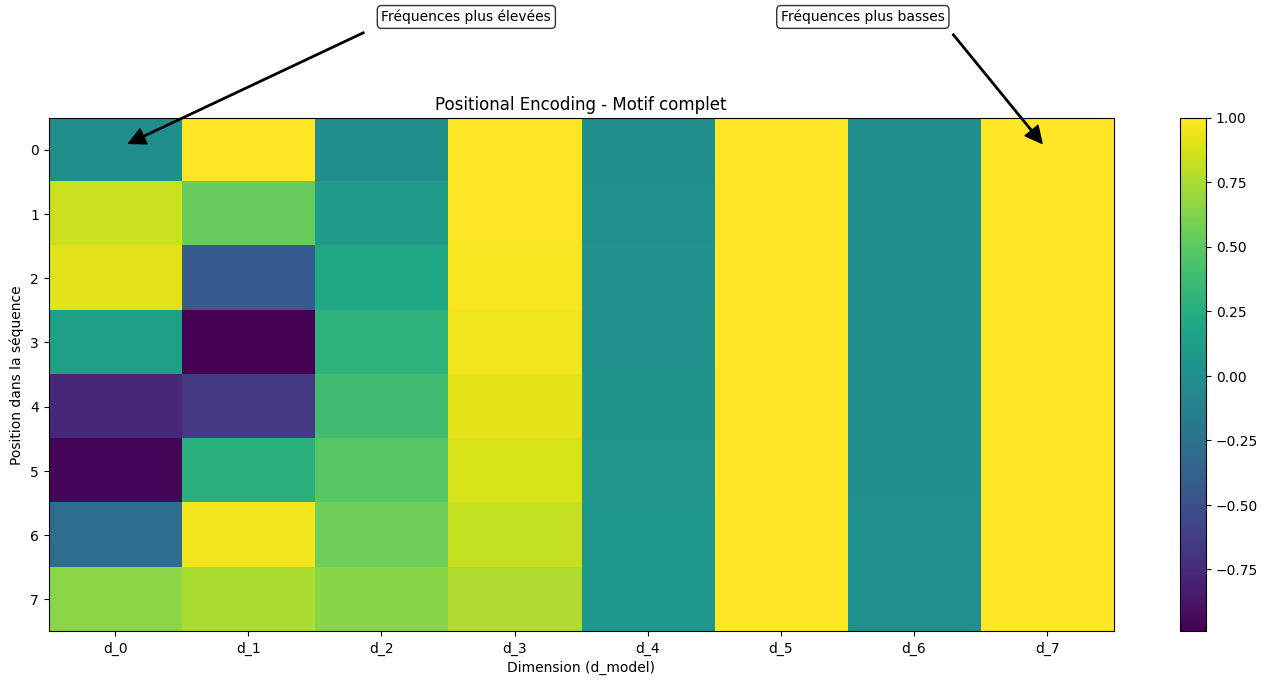

In [12]:
# Visualisation du motif complet
plt.figure(figsize=(14, 7))
pos_enc = positional_encoding.pe[0, :seq_len, :].detach().numpy()
plt.imshow(pos_enc, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Positional Encoding - Motif complet")
plt.xlabel("Dimension (d_model)")
plt.ylabel("Position dans la s√©quence")
plt.xticks(range(d_model), [f'd_{i}' for i in range(d_model)])
plt.yticks(range(seq_len), [i for i in range(seq_len)])

# Annotations
plt.annotate("Fr√©quences plus basses", 
            xy=(d_model-1, 0),  # point de d√©part de la fl√®che
            xytext=(d_model-3, -2),  # position du texte
            arrowprops=dict(facecolor='black', shrink=0.05, width=1),
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

plt.annotate("Fr√©quences plus √©lev√©es", 
            xy=(0, 0),  # point de d√©part de la fl√®che
            xytext=(2, -2),  # position du texte
            arrowprops=dict(facecolor='black', shrink=0.05, width=1),
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

plt.tight_layout()
plt.show()

### Comprendre le motif du Positional Encoding

Le motif que nous observons s'explique par les diff√©rentes fr√©quences utilis√©es dans l'encodage :

- **Dimensions basses (gauche)** : Les fr√©quences sont plus √©lev√©es (division par un petit nombre), ce qui produit des variations plus rapides des valeurs de sinus et cosinus. C'est pourquoi on voit beaucoup de changements de couleurs.

- **Dimensions hautes (droite)** : Les fr√©quences sont tr√®s basses (division par un grand nombre), ce qui fait que :
  - Les dimensions paires (sin) restent proches de 0
  - Les dimensions impaires (cos) restent proches de 1

Cette structure permet au mod√®le de capturer des d√©pendances √† diff√©rentes √©chelles :
- Les dimensions basses capturent les relations de position fines
- Les dimensions hautes capturent les relations de position plus grossi√®res

C'est un peu comme avoir une r√®gle gradu√©e avec diff√©rentes pr√©cisions : millim√®tres d'un c√¥t√©, centim√®tres de l'autre.

Le graphique ci-dessous montre cette dynamique, plus la dimension est √©lev√©e, plus la fr√©quence est basse.

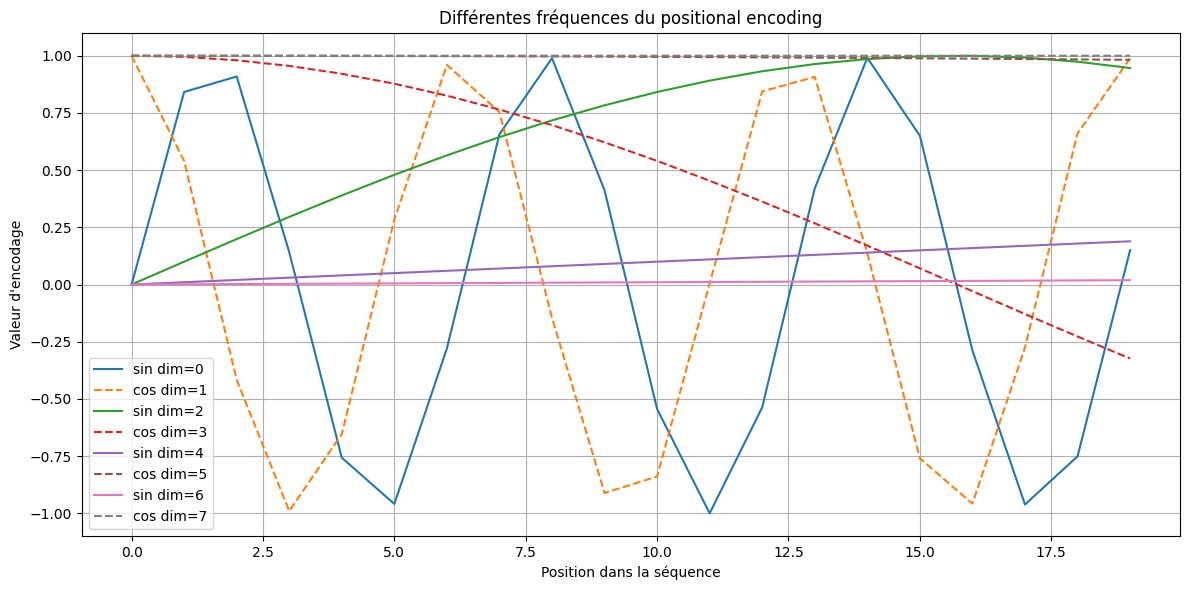

In [13]:
# Visualisation des diff√©rentes fr√©quences
plt.figure(figsize=(12, 6))
pos = np.arange(20)  # 20 positions diff√©rentes
for i in range(d_model//2):
    # Calcul des valeurs sinus et cosinus
    wave_length = 10000 ** (2 * i / d_model)
    sin_values = np.sin(pos / wave_length)
    cos_values = np.cos(pos / wave_length)
    
    plt.plot(pos, sin_values, label=f'sin dim={2*i}', linestyle='-')
    plt.plot(pos, cos_values, label=f'cos dim={2*i+1}', linestyle='--')

plt.title("Diff√©rentes fr√©quences du positional encoding")
plt.xlabel("Position dans la s√©quence")
plt.ylabel("Valeur d'encodage")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Pourquoi cette approche ?

**Approche RNN (R√©seau de Neurones R√©current)**
- Pour chaque mot, le mod√®le :
  - Regarde le mot actuel
  - Utilise sa "m√©moire" des mots pr√©c√©dents
  - Met √† jour cette m√©moire
- ‚û°Ô∏è Comme quelqu'un qui lit en gardant le contexte en t√™te
- üö´ Probl√®me : plus la phrase est longue, plus il est difficile de maintenir un contexte pr√©cis

**Approche Transformer**
- Voit tous les mots simultan√©ment
- Peut directement connecter n'importe quels mots entre eux
- ‚û°Ô∏è Comme avoir une vue d'ensemble qui permet de relier directement les √©l√©ments pertinents
- ‚úÖ Mais pour cela, il faut que le mod√®le sache o√π se trouve chaque mot !

Le positional encoding, avec ses diff√©rentes fr√©quences, donne cette information de position :
- Les oscillations rapides (hautes fr√©quences) : distinguent les positions proches
- Les oscillations lentes (basses fr√©quences) : distinguent les positions √©loign√©es

C'est un peu comme avoir une r√®gle gradu√©e avec diff√©rentes pr√©cisions qui permet au mod√®le de mesurer facilement les distances entre les mots, qu'ils soient proches ou √©loign√©s.

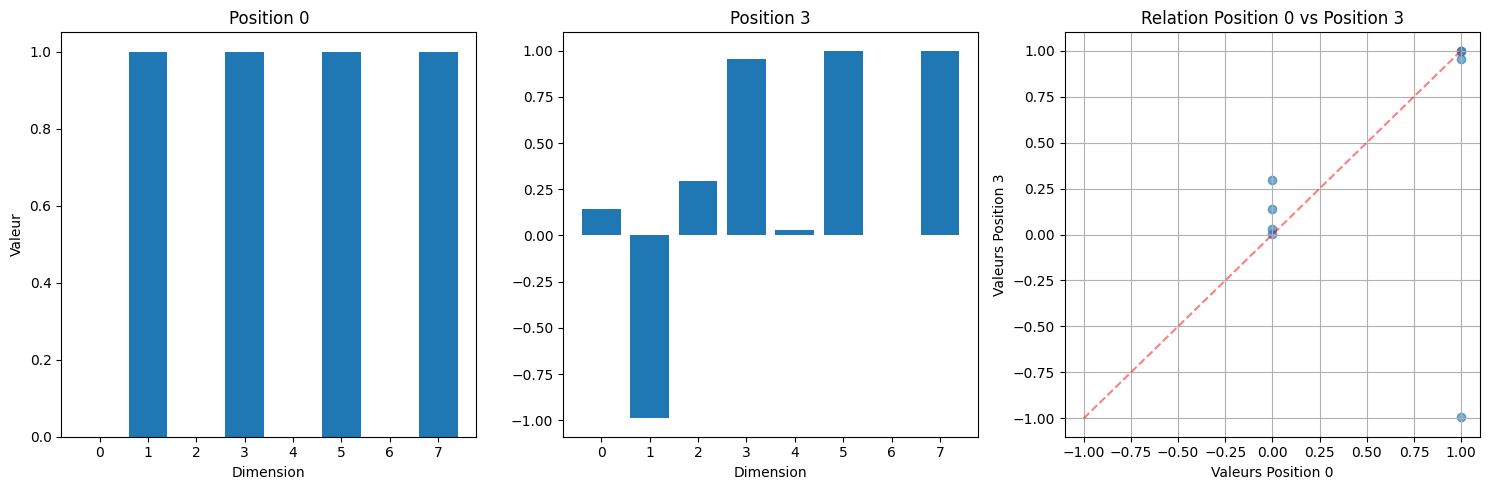

In [15]:
# Visualisation plus claire de la relation entre positions
plt.figure(figsize=(15, 5))

# 1. Position originale
plt.subplot(1, 3, 1)
pos0 = positional_encoding.pe[0, 0, :].detach().numpy()
plt.bar(range(d_model), pos0)
plt.title("Position 0")
plt.xlabel("Dimension")
plt.ylabel("Valeur")

# 2. Position d√©cal√©e
plt.subplot(1, 3, 2)
pos3 = positional_encoding.pe[0, 3, :].detach().numpy()
plt.bar(range(d_model), pos3)
plt.title("Position 3")
plt.xlabel("Dimension")

# 3. Relation entre les deux
plt.subplot(1, 3, 3)
plt.scatter(pos0, pos3, alpha=0.6)
plt.plot([-1, 1], [-1, 1], 'r--', alpha=0.5)  # ligne de r√©f√©rence
plt.title("Relation Position 0 vs Position 3")
plt.xlabel("Valeurs Position 0")
plt.ylabel("Valeurs Position 3")
plt.grid(True)

plt.tight_layout()
plt.show()

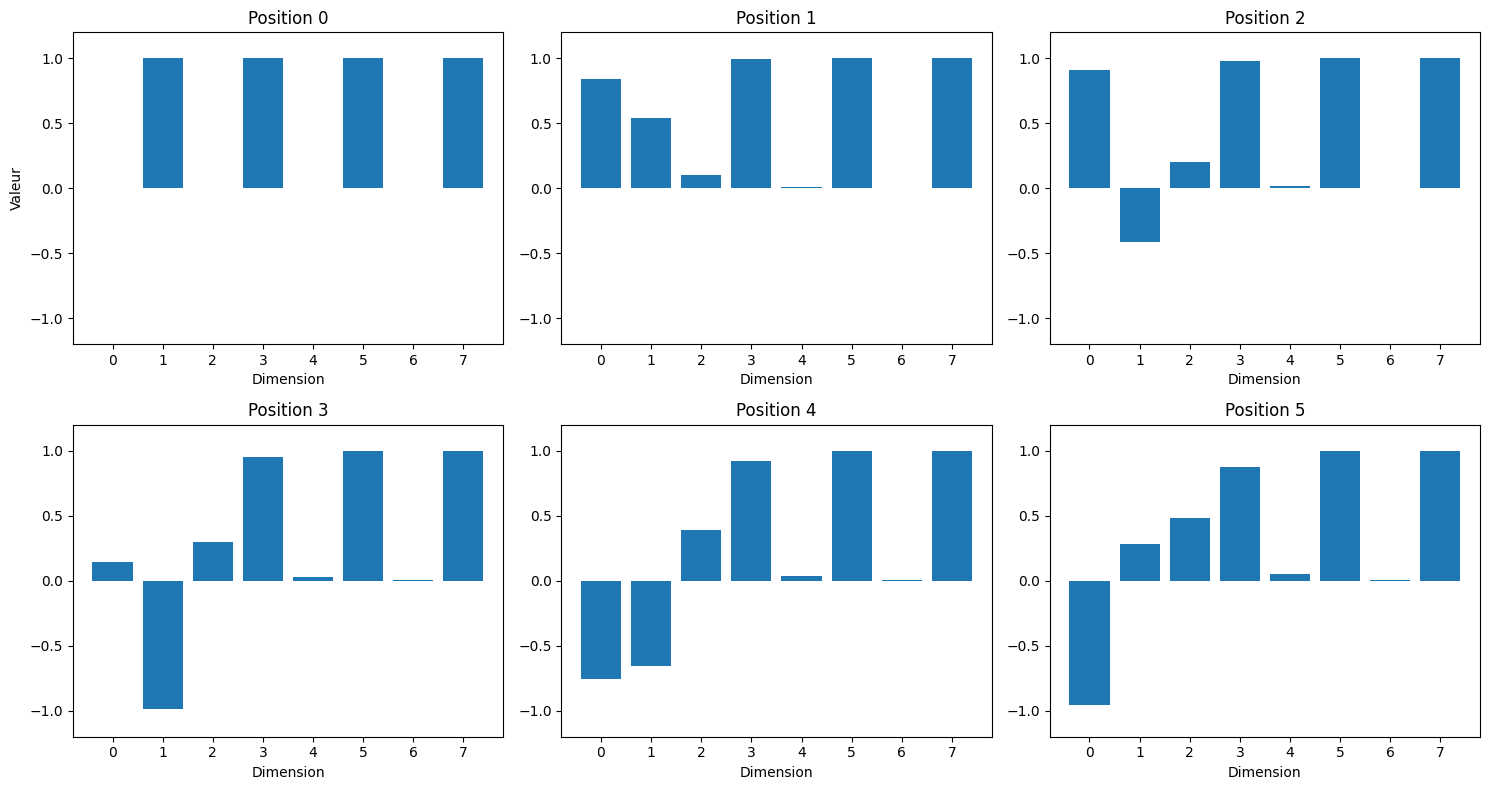

In [20]:
# Visualisation de l'√©volution des valeurs sur plusieurs positions
plt.figure(figsize=(15, 8))
positions = [0, 1, 2, 3, 4, 5]  # On regarde les 6 premi√®res positions

for i, pos in enumerate(positions):
    plt.subplot(2, 3, i+1)
    values = positional_encoding.pe[0, pos, :].detach().numpy()
    plt.bar(range(d_model), values)
    plt.title(f"Position {pos}")
    plt.xlabel("Dimension")
    plt.ylabel("Valeur" if i == 0 else "")
    plt.ylim(-1.2, 1.2)  # Fixe l'√©chelle pour toutes les visualisations

plt.tight_layout()
plt.show()

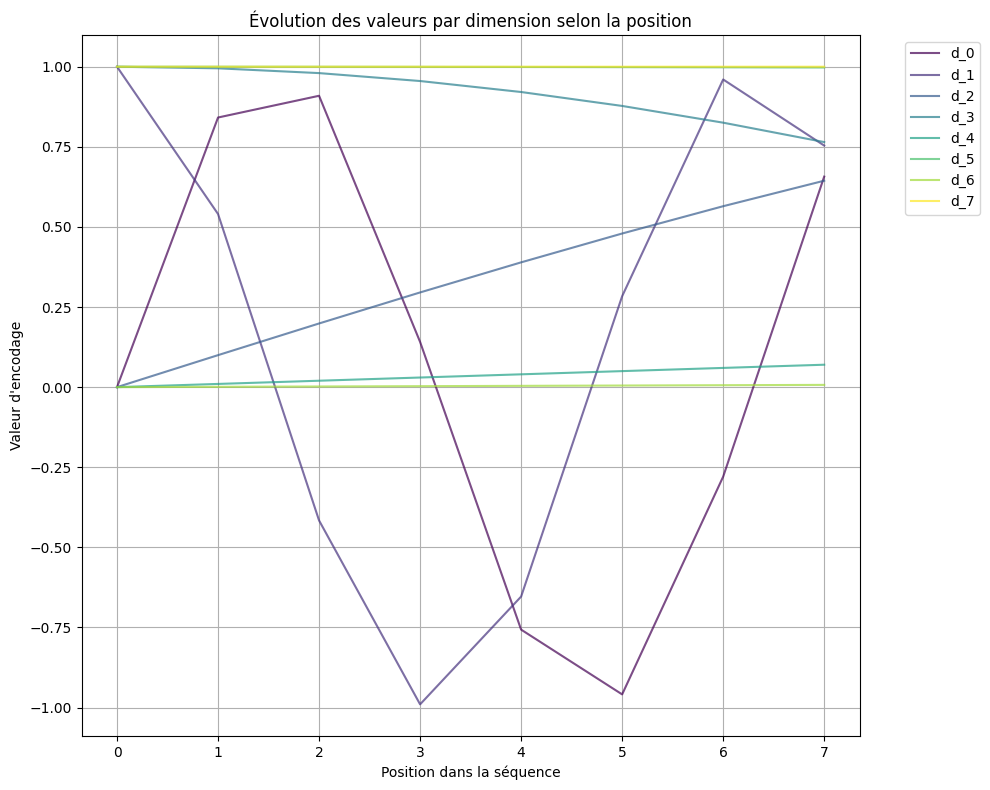

In [23]:
# Visualisation de l'√©volution sur un rep√®re 2D
plt.figure(figsize=(10, 8))
colors = plt.cm.viridis(np.linspace(0, 1, d_model))  # Une couleur par dimension
max_pos = 8  # On limite aux 8 premi√®res positions

for dim in range(d_model):
    values = [positional_encoding.pe[0, pos, dim].item() for pos in range(max_pos)]
    plt.plot(range(max_pos), values, label=f'd_{dim}', color=colors[dim], alpha=0.7)

plt.title("√âvolution des valeurs par dimension selon la position")
plt.xlabel("Position dans la s√©quence")
plt.ylabel("Valeur d'encodage")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Les histogrammes** montrent les valeurs pour chaque dimension √† une position donn√©e :
- √Ä la position 0 : dimensions paires (sin) = 0, dimensions impaires (cos) = 1
- Au fur et √† mesure que la position augmente, les valeurs √©voluent diff√©remment selon les dimensions
- Chaque position obtient ainsi un "code-barres" unique qui la caract√©rise

C'est comme un orchestre o√π chaque dimension joue sa note √† son propre rythme, cr√©ant une m√©lodie unique pour chaque position !

In [16]:
# Obtention des embeddings
token_embeddings = embedding_layer(input_tensor)
pos_encodings = positional_encoding.pe[:, :token_embeddings.shape[1], :]
final_embeddings = token_embeddings + pos_encodings

print("Dimensions:")
print(f"Token embeddings: {token_embeddings.shape}")
print(f"Positional encodings: {pos_encodings.shape}")
print(f"Final embeddings: {final_embeddings.shape}")

Dimensions:
Token embeddings: torch.Size([2, 8, 8])
Positional encodings: torch.Size([1, 8, 8])
Final embeddings: torch.Size([2, 8, 8])


Dans le Transformer, les embeddings finaux sont la somme de:
- Token embeddings: repr√©sentation s√©mantique du token
- Positional encodings: information sur la position

Cette somme permet au mod√®le d'apprendre √† la fois:
- Le sens des mots individuels
- Les relations entre mots bas√©es sur leur position

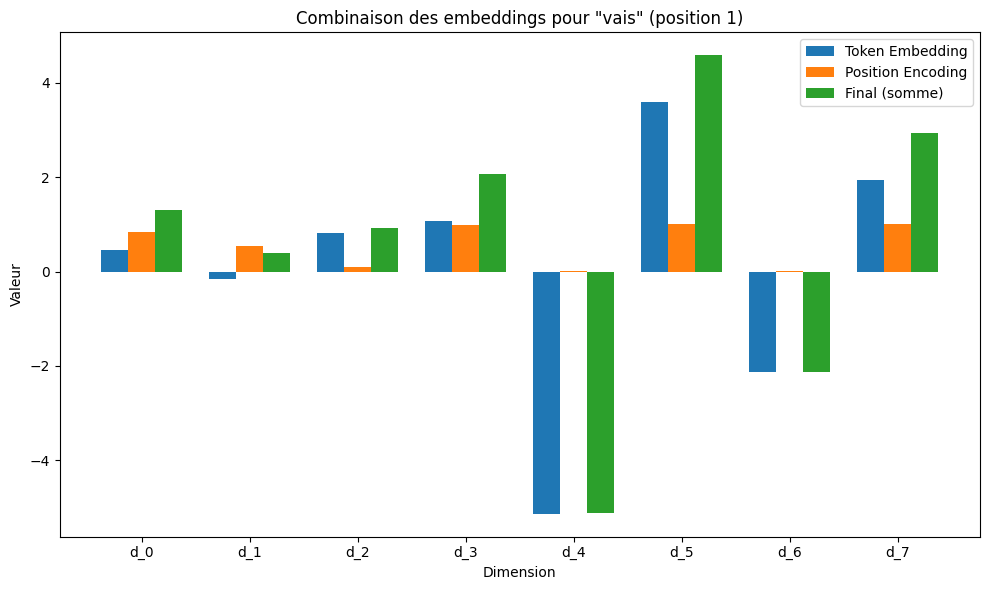

In [22]:
# Visualisation de la combinaison pour un token sp√©cifique
token_idx = 1  # "vais" dans la premi√®re phrase
plt.figure(figsize=(10, 6))
x = np.arange(d_model)
width = 0.25

embeds = token_embeddings[0, token_idx, :].detach().numpy()
pos_enc = pos_encodings[0, token_idx, :].detach().numpy()
final = final_embeddings[0, token_idx, :].detach().numpy()

plt.bar(x - width, embeds, width, label='Token Embedding')
plt.bar(x, pos_enc, width, label='Position Encoding')
plt.bar(x + width, final, width, label='Final (somme)')
plt.xlabel('Dimension')
plt.ylabel('Valeur')
plt.title(f'Combinaison des embeddings pour "{sentences[0][token_idx]}" (position {token_idx})')
plt.legend()
plt.xticks(range(d_model), [f'd_{i}' for i in range(d_model)])
plt.tight_layout()
plt.show()

Visualisons maintenant les embeddings finaux pour nos phrases d'exemple.
Cela nous permet de voir comment chaque token est repr√©sent√© dans l'espace vectoriel,
avec l'information de position int√©gr√©e.

In [18]:
# Visualisation des embeddings finaux pour la premi√®re phrase
def plot_embeddings(embeddings, title, tokens):
    plt.figure(figsize=(12, 6))
    plt.imshow(embeddings.detach().numpy(), aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.xticks(range(d_model), [f'd_{i}' for i in range(d_model)])
    plt.yticks(range(len(tokens)), tokens)
    plt.title(title)
    plt.xlabel("Dimension d'embedding")
    plt.ylabel("Tokens")
    plt.show()

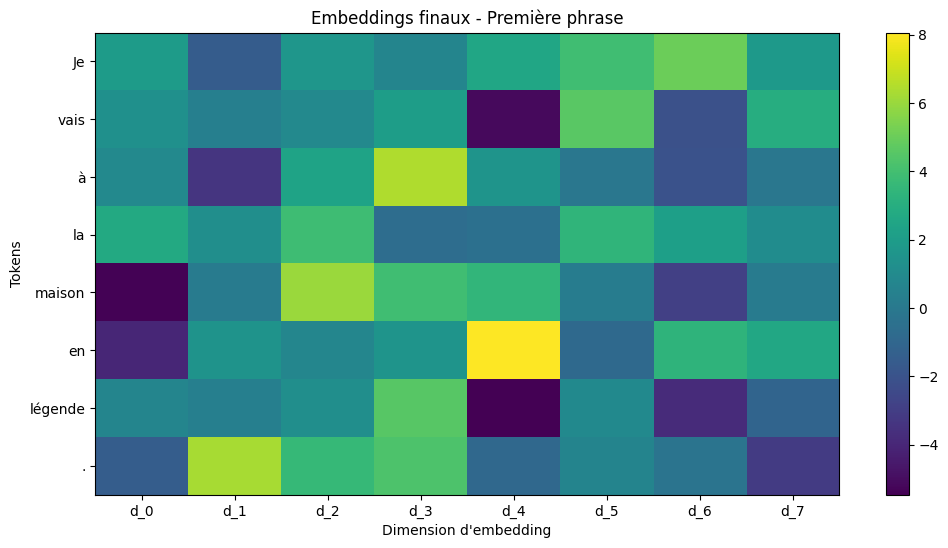

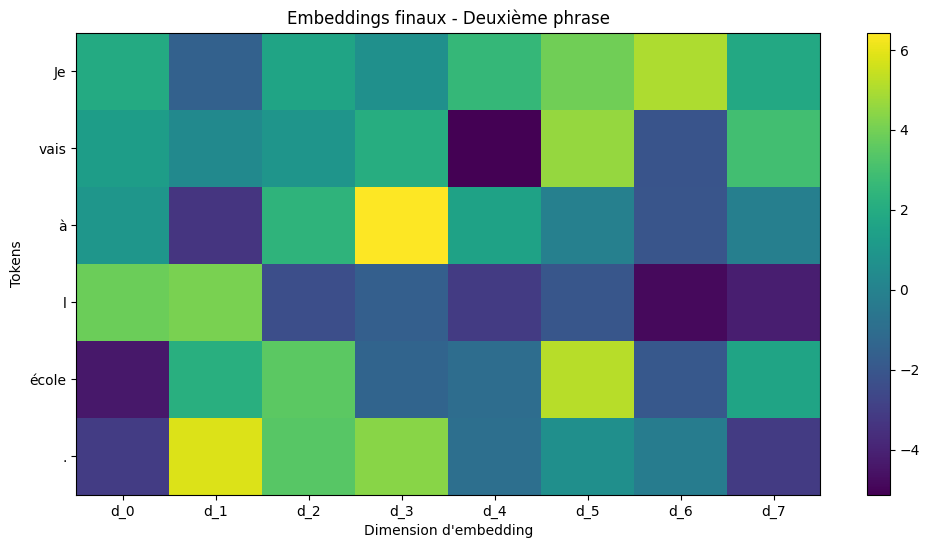

In [19]:
# Premi√®re phrase
first_sentence_emb = final_embeddings[0, :len(sentences[0]), :]
plot_embeddings(
    first_sentence_emb,
    "Embeddings finaux - Premi√®re phrase",
    sentences[0]
)

# Deuxi√®me phrase
second_sentence_emb = final_embeddings[1, :len(sentences[1]), :]
plot_embeddings(
    second_sentence_emb,
    "Embeddings finaux - Deuxi√®me phrase",
    sentences[1]
)

On voit que "Je" "vais" et "√†" sont proches dans l'espace vectoriel, ce qui est logique puisqu'ils ont le m√™me embedding et sont √† la m√™me position.

L'id√©e, c'est que le transformer saura rapprocher les mots "√©cole" et "maison" puisqu'ils sont √† la m√™me position et surtout ont des sens proches. Donc si le dataset d'entra√Ænement contient cette similarit√© relative, le transformer pourra apprendre √† rapprocher ces mots.

Si √† l'inverse le dataset d'entra√Ænement semble faire de ces mots des mots oppos√©s en tout, alors ils n'auront jamais d'embedding proche.